In [1]:
import torch
import torch.nn as nn

In [2]:
print(torch.__version__)

2.8.0+cu129


In [3]:
from torchinfo import summary

In [4]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        return x

In [5]:
summary(LeNet(), input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 24, 24]            156
├─Conv2d: 1-2                            [1, 16, 8, 8]             2,416
├─Flatten: 1-3                           [1, 256]                  --
├─Linear: 1-4                            [1, 120]                  30,840
├─Linear: 1-5                            [1, 84]                   10,164
├─Linear: 1-6                            [1, 10]                   850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.18
Estimated Total Size (MB): 0.22

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import *
import numpy as np
import sys

torch.manual_seed(0)

model = LeNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True,
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True,
)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

num_epochs = 10
loss_hitory = []
acc_history = []

for epoch in tqdm(range(num_epochs), file=sys.stdout):
    total_loss = 0
    total_correct = 0

    model.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = model(images)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    loss_hitory.append(np.log10(total_loss))
    acc_history.append(total_correct / len(test_dataset))

    if epoch % 2 == 0:
        tqdm.write(f"Epoch: {epoch:>5}, Loss: {loss_hitory[-1].item():>7.5f}, Accuracy: {acc_history[-1]:>7.5f}")

Epoch:     0, Loss: 2.73293, Accuracy: 0.10290
Epoch:     2, Loss: 2.73089, Accuracy: 0.34250
Epoch:     4, Loss: 2.71972, Accuracy: 0.50660
Epoch:     6, Loss: 2.40176, Accuracy: 0.69520
Epoch:     8, Loss: 2.28364, Accuracy: 0.72840
100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


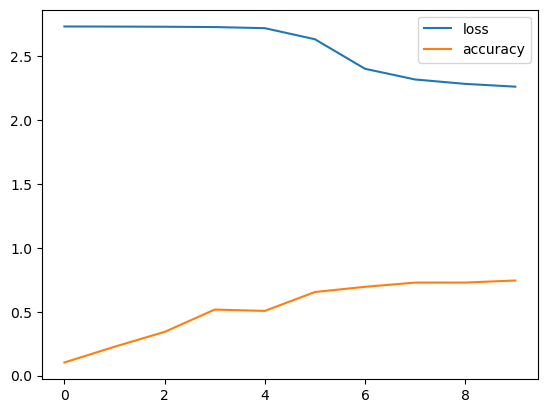

Accuracy on test set: 0.52


In [7]:
import matplotlib.pyplot as plt

plt.plot(loss_hitory, label="loss")
plt.plot(acc_history, label="accuracy")
plt.legend()
plt.show()

print(f"Accuracy on test set: {np.mean(acc_history):.2f}")